In [1]:
from keras.datasets import boston_housing
from keras import models
from keras import layers

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.
/home/pradip/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pradip/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pradip/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pradip/anaconda3/lib/python3.7/site-packages/tenso

In [2]:
# Loads data
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

57344/57026 [==============================] - 0s 7us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [7]:
# Prepares data

# normalizes data
train_data_mean = train_data.mean(axis=0)
train_data_std = train_data.std(axis=0)
train_data -= train_data_mean
train_data /= train_data_std

test_data -= train_data_mean
test_data /= train_data_std

# Seperates validation data
validation_samples_count = 104
x_validation = train_data[:validation_samples_count]
x_train = train_data[validation_samples_count:]

y_validation = train_labels[:validation_samples_count]
y_train = train_labels[validation_samples_count:]

In [8]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

In [9]:
 # Creates model
    
def create_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

In [10]:
# Trains model with Stand-out Validation

epoch_count = 100

model = create_model()
history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), 
                    batch_size=1, epochs=epoch_count, verbose=0)

In [17]:
history.history.keys()

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])

In [18]:
np.mean(history.history["val_mae"])

2.1182771027088165

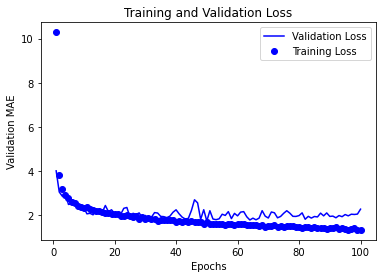

In [21]:
%matplotlib inline

plt.plot(range(1, epoch_count + 1), history.history["val_mae"], "b", label="Validation Loss")
plt.plot(range(1, epoch_count + 1),history.history["mae"], "bo", label="Training Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.legend()
plt.show()

In [22]:
# Now, trains model with K-Fold Validation

k_fold_validation_count = 4

def train_model(k_fold_validation_count, epoch_count):
    validation_samples_count = len(train_data)//k_fold_validation_count
    validation_mae_history = []
    for i in range(k_fold_validation_count):
        print("Processing fold #:", i)
        x_validation = train_data[i * validation_samples_count:(i+1)*validation_samples_count]
        y_validation = train_labels[i * validation_samples_count:(i+1)*validation_samples_count]

        x_train = np.concatenate(
            [train_data[:i*validation_samples_count], train_data[(i+1)*validation_samples_count:]], axis=0)
        y_train = np.concatenate(
            [train_labels[:i*validation_samples_count], train_labels[(i+1)*validation_samples_count:]], axis=0)

        model = create_model()
        history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), 
                            batch_size=1, epochs=epoch_count, verbose=0)
        print("    Average validation MAE ", np.average(history.history["val_mae"]))
        #validation_mse, validation_mae = model.evaluate(x_validation, y_validation, verbose=0)
        validation_mae_history.append(history.history["val_mae"])
        
    return validation_mae_history

validation_mae_history = train_model(4, 100)

Processing fold #: 0
    Average validation MAE  2.1041031169891355
Processing fold #: 1
    Average validation MAE  2.537714116573334
Processing fold #: 2
    Average validation MAE  2.7495487117767334
Processing fold #: 3
    Average validation MAE  2.5681263542175294


Processing fold #: 0
    Average validation MAE  2.287734848022461
Processing fold #: 1
    Average validation MAE  2.8706929802894594
Processing fold #: 2
    Average validation MAE  2.860826621055603
Processing fold #: 3
    Average validation MAE  2.828891839027405


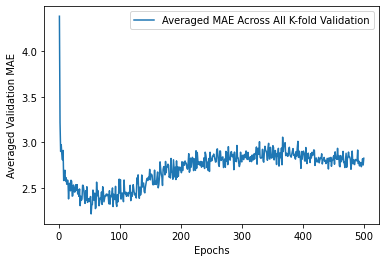

In [23]:
# Now, let's train the model over 500 epochs

k_fold_validation_count = 4
epoch_count = 500

validation_mae_history = train_model(k_fold_validation_count, epoch_count)
averaged_mae_across_all_k_fold_validation = np.mean(validation_mae_history, axis=0)

plt.plot(range(1, epoch_count + 1), averaged_mae_across_all_k_fold_validation, label="Averaged MAE Across All K-fold Validation")
plt.xlabel("Epochs")
plt.ylabel("Averaged Validation MAE")
plt.legend()
plt.show()

In [39]:
averaged_mae_across_all_k_fold_validation[:10]

array([4.37867624, 3.22017086, 2.90228927, 2.97433299, 2.86528206,
       2.81082463, 2.91342247, 2.58480895, 2.65660566, 2.69696999])

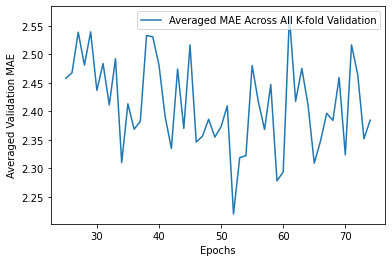

In [40]:
# It is difficult to realize the above plat due to MAE scaling issue.
# It seems validation MAE is lowest at some epoch between 0 to 100. Let's plot epochs in the range between 25 to 75.

plt.plot(range(25, 75), averaged_mae_across_all_k_fold_validation[25:75], 
         label="Averaged MAE Across All K-fold Validation")
plt.xlabel("Epochs")
plt.ylabel("Averaged Validation MAE")
plt.legend()
plt.show()

In [46]:
# Let's get that epoch where average MAE is lowest from history

epoch_count_min = np.argmin(averaged_mae_across_all_k_fold_validation)
# OR epoch = np.where(averaged_mae_across_all_k_fold_validation == averaged_mae_across_all_k_fold_validation.min())

epoch_count_min

52

In [47]:
# Let's now build the final model with this epoch count after combining validation data back into training data.

model = create_model()
model.fit(train_data, train_labels, epochs=epoch_count_min, batch_size=1)

test_mse, test_mae = model.evaluate(test_data, test_labels)

Epoch 1/52
404/404 [==============================] - 1s 2ms/step - loss: 136.2405 - mae: 8.4679
Epoch 2/52
404/404 [==============================] - 1s 2ms/step - loss: 22.9251 - mae: 3.0975
Epoch 3/52
404/404 [==============================] - 1s 2ms/step - loss: 18.9049 - mae: 2.7538
Epoch 4/52
404/404 [==============================] - 1s 2ms/step - loss: 15.3329 - mae: 2.5860
Epoch 5/52
404/404 [==============================] - 1s 2ms/step - loss: 14.5902 - mae: 2.4673
Epoch 6/52
404/404 [==============================] - 1s 2ms/step - loss: 13.2371 - mae: 2.4171
Epoch 7/52
404/404 [==============================] - 1s 2ms/step - loss: 12.2138 - mae: 2.3383
Epoch 8/52
404/404 [==============================] - 1s 2ms/step - loss: 12.1968 - mae: 2.3151
Epoch 9/52
404/404 [==============================] - 1s 2ms/step - loss: 11.5026 - mae: 2.2726
Epoch 10/52
404/404 [==============================] - 1s 2ms/step - loss: 11.3361 - mae: 2.2357
Epoch 11/52
404/404 [=================

In [48]:
print("Test MSE:", test_mse, ", Test MAE:", test_mae)

Test MSE: 12.966181885962392 , Test MAE: 2.413651704788208
